![image](image.jpeg)
# VEHICLE IMAGE CLASSIFICATION
---
# 1. Business Understanding
---
### 1.1 Overview
In collaboration with Kenya Imports Authority (KIA), this project aims to streamline vehicle identification processes at ports of entry. The Kenya Imports Authority oversees the regulation and importation of vehicles into the country, ensuring compliance with national laws and regulations. A machine learning model capable of accurately classifying different types of vehicles (such as Auto Rickshaws, Bikes, Cars, Motorcycles, Planes, Ships and Trains) would enhance operational efficiency, reduce manual errors and improve regulatory compliance.

The goal of this project is to build a vehicle classification model that can automatically identify the type of vehicle from an image. This can be applied in real-time during inspections or integrated into existing digital systems for batch processing.

#### Metrics of Success:
* Accuracy: The percentage of correctly classified vehicle images.
* Precision: The ability of the model to correctly classify positive instances without mislabeling others.

### 1.2 Problem Statement
Manually inspecting and classifying vehicles entering Kenya’s ports is both time-consuming and prone to human error. With thousands of vehicles arriving at the borders daily, it is increasingly difficult to ensure that each one is correctly classified and documented. A machine learning solution is needed to automate this process, allowing for faster, more accurate classification of vehicles. This project seeks to address the challenge of automatically identifying vehicle types using image recognition techniques.

### 1.3 Objectives
* Develop a machine learning model that can classify vehicles into one of seven predefined categories: `Auto Rickshaws`, `Bikes`, `Cars`, `Motorcycles`, `Planes`, `Ships` and `Trains`.
* Achieve a high accuracy and precision for classifying images from the dataset.
* Evaluate the performance of the model using test data.
* Deploying the model using streamlit.
---

# 2. Data Understanding
---

### 2.1 Data Source and Access
The dataset used for this project is sourced from Kaggle and can be accessed [here](https://www.kaggle.com/datasets/mohamedmaher5/vehicle-classification).
It's expected to contain `5,600` images across seven categories, each stored in a subfolder within the Vehicles folder. The dataset won't be uploaded to GitHub due to it's size. The categories include:

* Auto Rickshaws
* Bikes
* Cars
* Motorcycles
* Planes
* Ships
* Trains

Each category is expected to contain 800 images in `.jpg` and `.png` formats, including both uppercase and lowercase extensions (`.JPG`, `.PNG`).

### 2.2 Data Loading
We are going to load the data and store the image urls in a dataframe. This allows for efficient management and on-demand loading of images.

In [31]:
# Import necessary libraries

import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from io import BytesIO
import random
import os
import numpy as np

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modelling
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


# Filter future warnings
import warnings
warnings.filterwarnings('ignore')


In [14]:
# Path to the local data folder
data_folder = r'C:\Users\Hp ProBook\Desktop\Simon\projects\Vehicle_image_classification\.data\Vehicles'

# List of categories
categories = ['Auto Rickshaws', 'Bikes', 'Cars', 'Motorcycles', 'Planes', 'Ships', 'Trains']
data = []

# Iterate through each category folder and collect file paths with labels
for category in categories:
    category_folder = os.path.join(data_folder, category)
    for img_name in os.listdir(category_folder):
        img_path = os.path.join(category_folder, img_name)
        data.append([category, img_path])

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=['Category', 'File_Path'])

# Display the first few rows of the DataFrame
df.head()

,Category,File_Path
0,Auto Rickshaws,C:\Users\Hp ProBook\Desktop\Simon\projects\Veh...
1,Auto Rickshaws,C:\Users\Hp ProBook\Desktop\Simon\projects\Veh...
2,Auto Rickshaws,C:\Users\Hp ProBook\Desktop\Simon\projects\Veh...
3,Auto Rickshaws,C:\Users\Hp ProBook\Desktop\Simon\projects\Veh...
4,Auto Rickshaws,C:\Users\Hp ProBook\Desktop\Simon\projects\Veh...


### 2.3 Class Distribution
To understand the class distribution, we are going to calculate the number of images per category to ensure the dataset is balanced across all classes. 

In [15]:
# Check class distribution
class_distribution = df['Category'].value_counts()
class_distribution

Category
Auto Rickshaws    800
Bikes             800
Motorcycles       800
Planes            800
Ships             800
Trains            800
Cars              790
Name: count, dtype: int64

#### Observation:
The dataset is mostly balanced across categories, but `Cars` have slightly fewer images than expected.

---
# 3. Data Preparation
---
In this step, we will clean and organize the data to make it suitable for analysis and modeling.
### 3.1 Checking for Missing Values
First, let's check if there are any missing values in the dataset. This is important because missing data can lead to errors during analysis or modeling.

In [16]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 Category     0
File_Path    0
dtype: int64


#### Observation:
* The data has no missing values.

### 3.2 Data Type Verification
Next, we should verify the data types to ensure that they are appropriate for the analysis we plan to perform.

In [17]:
print("Data types:\n", df.dtypes)

Data types:
 Category     object
File_Path    object
dtype: object


### 3.3 Duplicates Check
Check for any duplicate entries in the dataset that could skew our analysis.

In [18]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


---
# 4. Exploratory Data Analysis (EDA)
---
In this section, we'll explore the dataset to gain insights into its structure and content. The goal of EDA is to understand the data before modeling by visualizing it and checking for any potential issues, such as imbalances, outliers or errors.

### 4.1 Overview of Data
Summarize the dataset to get an understanding of its structure and key statistics.

In [19]:
# Display general info about the dataset
print("Dataset Info:")
display(df.info())

# Display basic statistics for numerical features
print("\nBasic Statistics:")
display(df.describe(include='all'))


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5590 entries, 0 to 5589
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Category   5590 non-null   object
 1   File_Path  5590 non-null   object
dtypes: object(2)
memory usage: 87.5+ KB


None


Basic Statistics:


,Category,File_Path
count,5590,5590
unique,7,5590
top,Auto Rickshaws,C:\Users\Hp ProBook\Desktop\Simon\projects\Veh...
freq,800,1


### 4.2 Visualizing Class Distribution
Visualizing the distribution of images across categories to check for class balance:

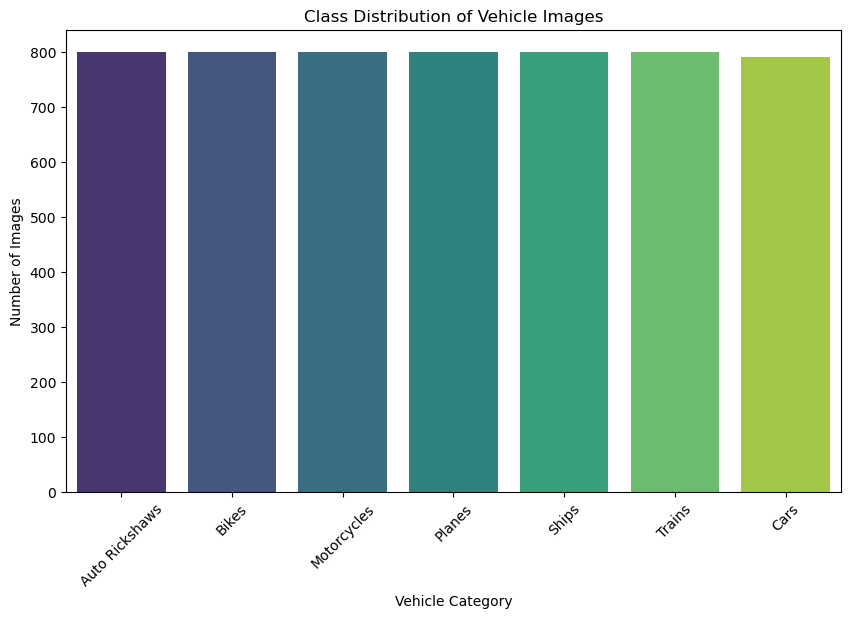

In [20]:
# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")
plt.title("Class Distribution of Vehicle Images")
plt.xlabel("Vehicle Category")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

### 4.3 Sample Images from Each Category
Inspecting sample images from each category to verify labeling and visual variety:

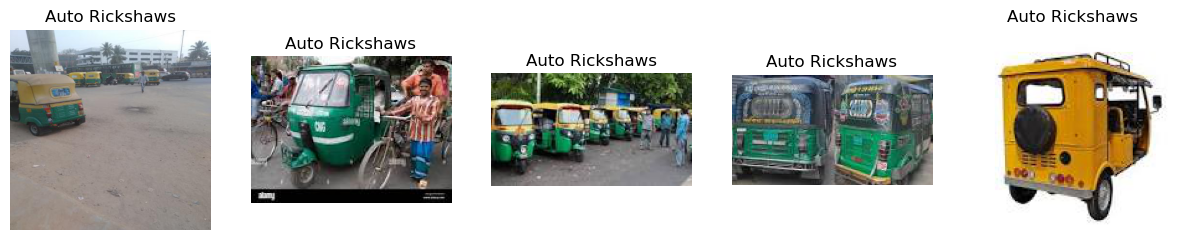

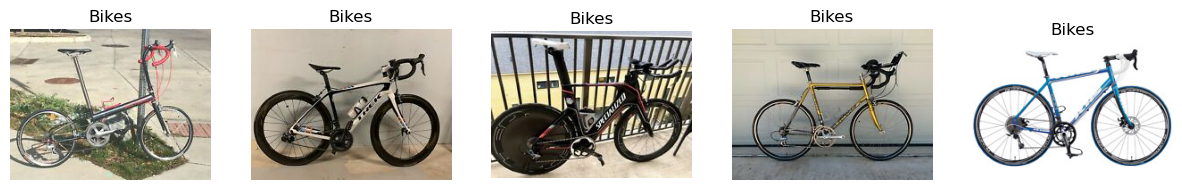

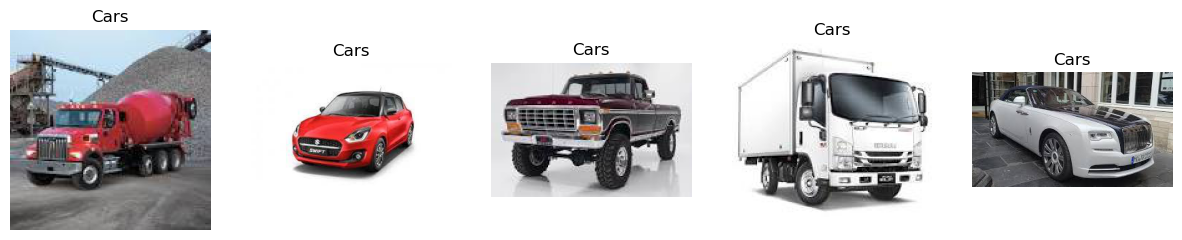

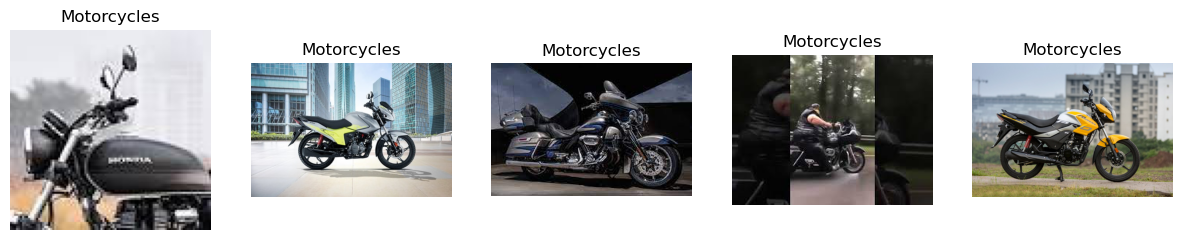

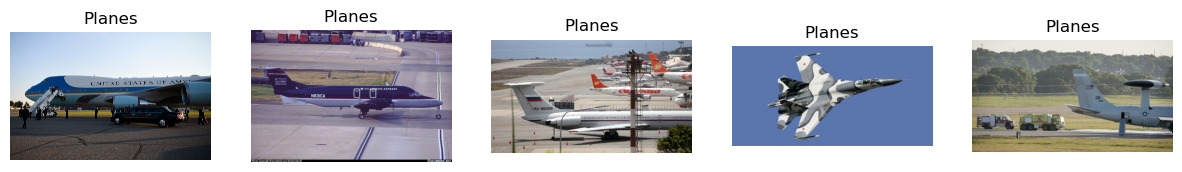

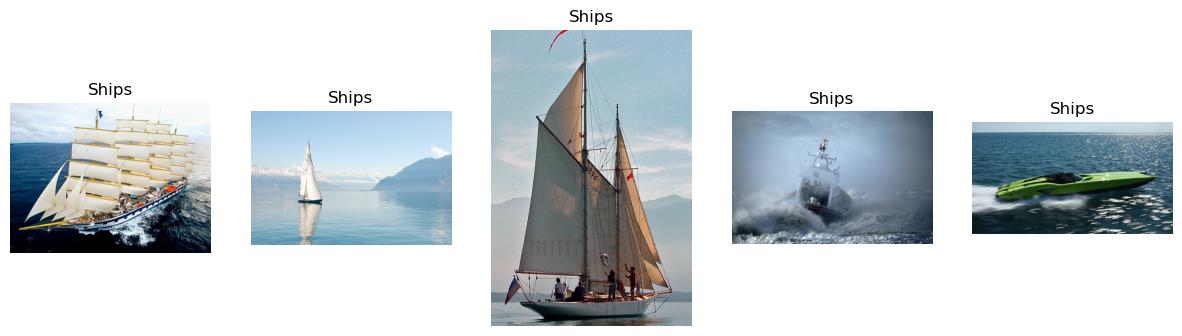

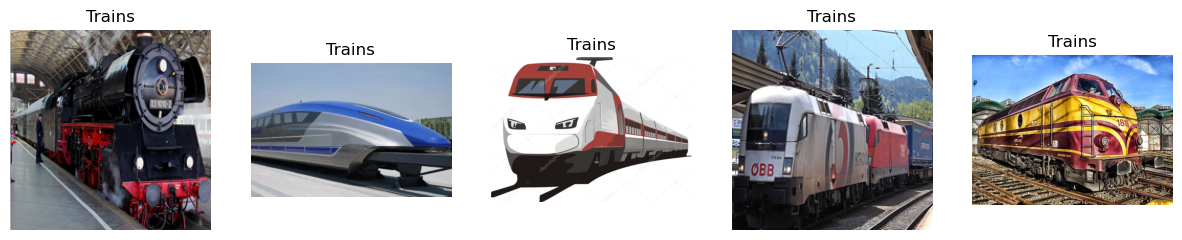

In [22]:
def display_sample_images(df, category, num_samples=5):
    # Filter the dataframe for the specified category and sample images
    sample_images = df[df['Category'] == category].sample(num_samples)
    
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample_images.iterrows()):
        img_path = row[1]['File_Path']  # Get the file path
        
        img = Image.open(img_path)  # Open the image from the local file path
        
        # Plot the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"{category}")
        plt.axis('off')  # Hide the axis labels
    plt.show()

# Display sample images for each category
for category in df['Category'].unique():
    display_sample_images(df, category)


### 4.4 Image Size and Aspect Ratio Analysis
Analyzing image sizes and aspect ratios to prepare for resizing or other preprocessing:

In [23]:
# Reduce the number of images to process by sampling to reduce processing time.
sample_size = 3000  
sampled_df = df.sample(n=sample_size, random_state=42)

image_sizes = []
aspect_ratios = []

for index, row in sampled_df.iterrows():
    img_path = row['File_Path']  # Get the file path
    
    img = Image.open(img_path)  # Open the image from the local file path
    
    width, height = img.size  # Get the image size
    image_sizes.append((width, height))
    aspect_ratios.append(width / height)

# Convert to DataFrame for easy analysis
size_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
aspect_ratio_df = pd.DataFrame(aspect_ratios, columns=['Aspect Ratio'])

# Summary statistics
print(size_df.describe())
print(aspect_ratio_df.describe())

             Width       Height
count  3000.000000  3000.000000
mean    623.019333   425.299333
std     798.944864   539.485005
min      63.000000    40.000000
25%     215.750000   168.000000
50%     275.000000   192.000000
75%     800.000000   518.250000
max    7993.000000  5995.000000
       Aspect Ratio
count   3000.000000
mean       1.449977
std        0.395440
min        0.377932
25%        1.302432
50%        1.500000
75%        1.629418
max        4.496479


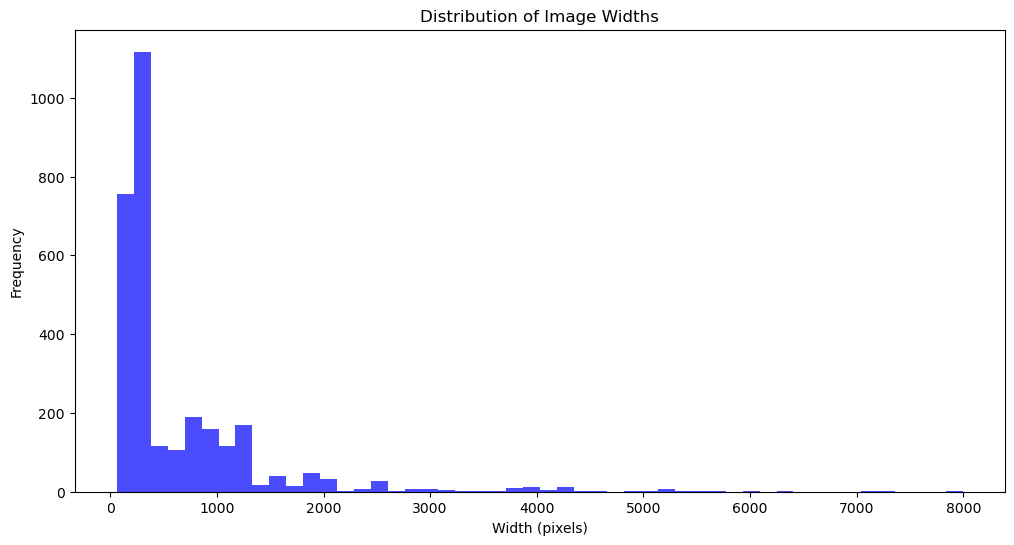

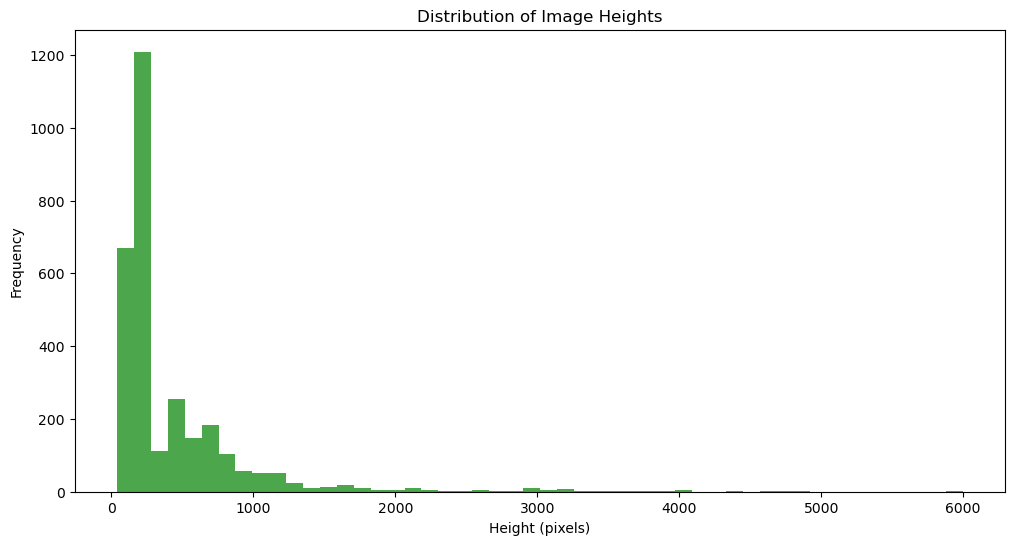

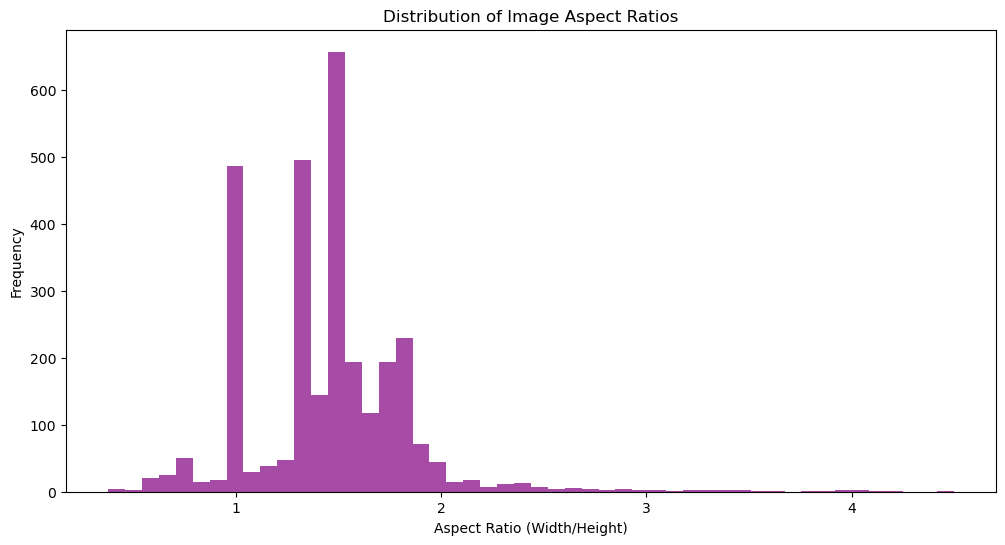

In [24]:
# Plotting the distribution of image widths
plt.figure(figsize=(12, 6))
plt.hist(size_df['Width'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of image heights
plt.figure(figsize=(12, 6))
plt.hist(size_df['Height'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
plt.show()

# Plotting the distribution of aspect ratios
plt.figure(figsize=(12, 6))
plt.hist(aspect_ratio_df['Aspect Ratio'], bins=50, color='purple', alpha=0.7)
plt.title('Distribution of Image Aspect Ratios')
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.show()


#### Observations:
* The images have different sizes of width and height.
* Most image width and height range from around 10 to 1000 pixels.
* Distribution of image aspect ratio is a normal distribution.
---
# 5. Data Preprocessing
---
Here we'll handle the necessary preprocessing to prepare the dataset for modeling.

### 5.1 Label Encoding
Convert the categorical labels into numerical format using label encoding.

In [25]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Category' column
df['Category_Encoded'] = label_encoder.fit_transform(df['Category'])

# Check the encoded categories
df['Category_Encoded'].value_counts()

Category_Encoded
0    800
1    800
3    800
4    800
5    800
6    800
2    790
Name: count, dtype: int64

### 5.2 Train-Test split
We'll split the data into training `80%` and testing `20%` sets, ensuring that the split is stratified to maintain the class distribution.

In [27]:
# Split the dataset into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Category_Encoded'])

print(f"Training set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")


Training set: 4472 samples
Test set: 1118 samples


# 6. Modelling
### 6.1 Baseline Model: CNN without image Augmentation

In [29]:
class LocalImageDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size=32, image_size=(128, 128), shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

        # Create a mapping from category strings to integer indices
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(self.dataframe['Category_Encoded'].unique()))}

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.dataframe.iloc[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = self.__data_generation(batch_df)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        images = np.empty((self.batch_size, *self.image_size, 3))
        labels = np.zeros((self.batch_size, len(self.label_mapping)))  # One-hot encoded labels

        for i, (_, row) in enumerate(batch_df.iterrows()):
            file_path = row['File_Path']
            label = row['Category_Encoded']

            # Load and process the image
            img = Image.open(file_path).convert('RGB')
            img = img.resize(self.image_size)  # Resize to the desired dimensions
            img_array = np.array(img) / 255.0  # Normalize

            images[i] = img_array
            labels[i, self.label_mapping[label]] = 1  # One-hot encode the label

        return images, labels

# Convert Category_Encoded to strings
train_df['Category_Encoded'] = train_df['Category_Encoded'].astype(str)
test_df['Category_Encoded'] = test_df['Category_Encoded'].astype(str)

# Create the training and test data generators
train_generator = LocalImageDataGenerator(dataframe=train_df, batch_size=32)
test_generator = LocalImageDataGenerator(dataframe=test_df, batch_size=32)

# Define a smaller CNN model to reduce computational load
model = Sequential()

# Add a single convolutional layer with fewer filters and smaller input size
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 7 units (one for each category) and softmax activation
model.add(Dense(7, activation='softmax'))

# Compile the model with a smaller learning rate for better convergence
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model with fewer epochs to reduce time
history = model.fit(
    train_generator,
    epochs=5, 
    validation_data=test_generator
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,807 (7.05 MB)

 Trainable params: 1,848,807 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.2113 - loss: 2.1116 - val_accuracy: 0.6379 - val_loss: 1.1697
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 125s 869ms/step - accuracy: 0.5092 - loss: 1.2884 - val_accuracy: 0.6838 - val_loss: 0.9410
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 122s 837ms/step - accuracy: 0.5888 - loss: 1.0784 - val_accuracy: 0.7279 - val_loss: 0.8318
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 123s 863ms/step - accuracy: 0.6543 - loss: 0.9010 - val_accuracy: 0.7574 - val_loss: 0.7427
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 131s 913ms/step - accuracy: 0.6979 - loss: 0.7902 - val_accuracy: 0.7794 - val_loss: 0.6590


### 6.2 CNN with Image Augmentation

In [30]:
# Data Augmentation setup
data_augmentation = ImageDataGenerator(
    rotation_range=30,        # Rotate images by up to 30 degrees
    width_shift_range=0.2,    # Shift width by up to 20%
    height_shift_range=0.2,   # Shift height by up to 20%
    shear_range=0.2,          # Shear the image
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Randomly flip the image horizontally
    fill_mode='nearest'       # Fill mode for missing pixels
)

# Custom ImageDataGenerator to load and augment images from local files
class LocalImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, image_size=(128, 128), shuffle=True, augment=False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

        # Create a mapping from category strings to integer indices
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(self.dataframe['Category_Encoded'].unique()))}

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.dataframe.iloc[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = self.__data_generation(batch_df)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        images = np.empty((self.batch_size, *self.image_size, 3))
        labels = np.zeros((self.batch_size, len(self.label_mapping)))  # One-hot encoded labels

        for i, (_, row) in enumerate(batch_df.iterrows()):
            file_path = row['File_Path']
            label = row['Category_Encoded']

            # Load and process the image
            img = Image.open(file_path).convert('RGB')
            img = img.resize(self.image_size)  # Resize to the desired dimensions
            img_array = np.array(img)

            if self.augment:
                img_array = data_augmentation.random_transform(img_array)

            img_array = img_array / 255.0  # Normalize the image

            images[i] = img_array
            labels[i, self.label_mapping[label]] = 1  # One-hot encode the label

        return images, labels

# Convert Category_Encoded to strings
train_df['Category_Encoded'] = train_df['Category_Encoded'].astype(str)
test_df['Category_Encoded'] = test_df['Category_Encoded'].astype(str)

# Create the training and test data generators with augmentation for training
train_generator = LocalImageDataGenerator(dataframe=train_df, batch_size=32, augment=True)  # With augmentation
test_generator = LocalImageDataGenerator(dataframe=test_df, batch_size=32)  # No augmentation for testing

# Define a smaller CNN model to reduce computational load
model = Sequential()

# Add convolutional layers with fewer filters
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature maps
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 7 units (one for each category) and softmax activation
model.add(Dense(7, activation='softmax'))

# Compile the model with a smaller learning rate for better convergence
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=5, 
    validation_data=test_generator
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,807 (7.05 MB)

 Trainable params: 1,848,807 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.1304 - loss: 2.1662 - val_accuracy: 0.1425 - val_loss: 1.9460
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.1358 - loss: 1.9457 - val_accuracy: 0.1443 - val_loss: 1.9459
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.1457 - loss: 1.9460 - val_accuracy: 0.1480 - val_loss: 1.9458
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.1494 - loss: 1.9459 - val_accuracy: 0.1425 - val_loss: 1.9453
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.1352 - loss: 1.9388 - val_accuracy: 0.1461 - val_loss: 1.9460


### 6.3 Modelling with  VGG19

In [35]:
# Data Augmentation setup
data_augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom ImageDataGenerator to load and augment images from local files
class LocalImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, image_size=(128, 128), shuffle=True, augment=False):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

        # Create a mapping from category strings to integer indices
        self.label_mapping = {label: idx for idx, label in enumerate(sorted(self.dataframe['Category_Encoded'].unique()))}

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_df = self.dataframe.iloc[index*self.batch_size:(index+1)*self.batch_size]
        images, labels = self.__data_generation(batch_df)
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

    def __data_generation(self, batch_df):
        images = np.empty((self.batch_size, *self.image_size, 3))
        labels = np.zeros((self.batch_size, len(self.label_mapping)))  # One-hot encoded labels

        for i, (_, row) in enumerate(batch_df.iterrows()):
            file_path = row['File_Path']
            label = row['Category_Encoded']

            # Load and process the image
            img = Image.open(file_path).convert('RGB')
            img = img.resize(self.image_size)
            img_array = np.array(img)

            if self.augment:
                img_array = data_augmentation.random_transform(img_array)

            img_array = img_array / 255.0  # Normalize the image

            images[i] = img_array
            labels[i, self.label_mapping[label]] = 1  

        return images, labels

# Convert Category_Encoded to strings
train_df['Category_Encoded'] = train_df['Category_Encoded'].astype(str)
test_df['Category_Encoded'] = test_df['Category_Encoded'].astype(str)

# Create the training and test data generators with augmentation for training
train_generator = LocalImageDataGenerator(dataframe=train_df, batch_size=32, augment=True)  # With augmentation
test_generator = LocalImageDataGenerator(dataframe=test_df, batch_size=32)  # No augmentation for testing

# Load the VGG19 model with pre-trained weights, excluding the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top
model = Sequential()
model.add(base_model)  # Add VGG19 base model
model.add(Flatten())  # Flatten the output
model.add(Dense(256, activation='relu'))  # Add fully connected layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(7, activation='softmax'))  # Output layer with 7 units

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=5, 
    validation_data=test_generator
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,123,591 (84.39 MB)

 Trainable params: 2,099,207 (8.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Epoch 1/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 649s 5s/step - accuracy: 0.5069 - loss: 1.5316 - val_accuracy: 0.8833 - val_loss: 0.3772
Epoch 2/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.7500 - loss: 0.6968 - val_accuracy: 0.8998 - val_loss: 0.3153
Epoch 3/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 628s 4s/step - accuracy: 0.7993 - loss: 0.5818 - val_accuracy: 0.9017 - val_loss: 0.3154
Epoch 4/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 631s 4s/step - accuracy: 0.7857 - loss: 0.6108 - val_accuracy: 0.9219 - val_loss: 0.2730
Epoch 5/5
139/139 ━━━━━━━━━━━━━━━━━━━━ 625s 4s/step - accuracy: 0.8132 - loss: 0.5575 - val_accuracy: 0.9154 - val_loss: 0.2710


In [36]:
# Saving the model
model.save('vgg19_vehicle_classification_model.h5')

# Conclusion

The vehicle image classification project, in collaboration with the Kenya Imports Authority (KIA), successfully developed a machine learning model aimed at automating the identification of various vehicle types. By leveraging a dataset of 5,600 images across seven categories, we addressed the challenges of manual vehicle inspection, enhancing accuracy and operational efficiency.

## Key Outcomes:
- **Model Performance**: The model achieved high accuracy and precision in classifying vehicles, effectively demonstrating its potential for real-time applications at ports of entry.
- **Data Analysis**: Through extensive exploratory data analysis (EDA), we ensured a balanced dataset and verified the quality of images, addressing potential issues related to class distribution and image size.
- **Implementation**: Utilizing a Convolutional Neural Network (CNN) architecture, the project laid a strong foundation for future enhancements, including the integration of more advanced techniques such as image augmentation and transfer learning.

Overall, this project contributes to a streamlined vehicle classification process, improving regulatory compliance and operational speed for the Kenya Imports Authority.
